In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numdifftools as nd

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from registration_utilities import *
from annotation_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [5]:
v1 = np.zeros((100,100,100))
v1[30:50, :-40, 40:60] = 1
v1 = np.pad(v1, 50, 'constant')

v2 = np.zeros((100,100,100))
v2[20:40, 40:, 40:60] = 1
v2 = np.pad(v2, 50, 'constant')

In [2]:
v1 = np.zeros((100,100,100))
v1[30:50, :, 40:60] = 1
v1[10:30, :, 40:60] = -1
v1[50:70, :, 40:60] = -1
v1 = np.pad(v1, 50, 'constant', constant_values=0)

v2 = np.zeros((100,100,100))
v2[20:40, 50:, 40:60] = 1
v2[:20, 50:, 40:60] = -1
v2[40:60, 50:, 40:60] = -1
v2[20:40, :50, 40:60] = -1
v2[40:60, :50, 40:60] = 1
v2[60:80, :50, 40:60] = -1
v2 = np.pad(v2, 50, 'constant', constant_values=0)

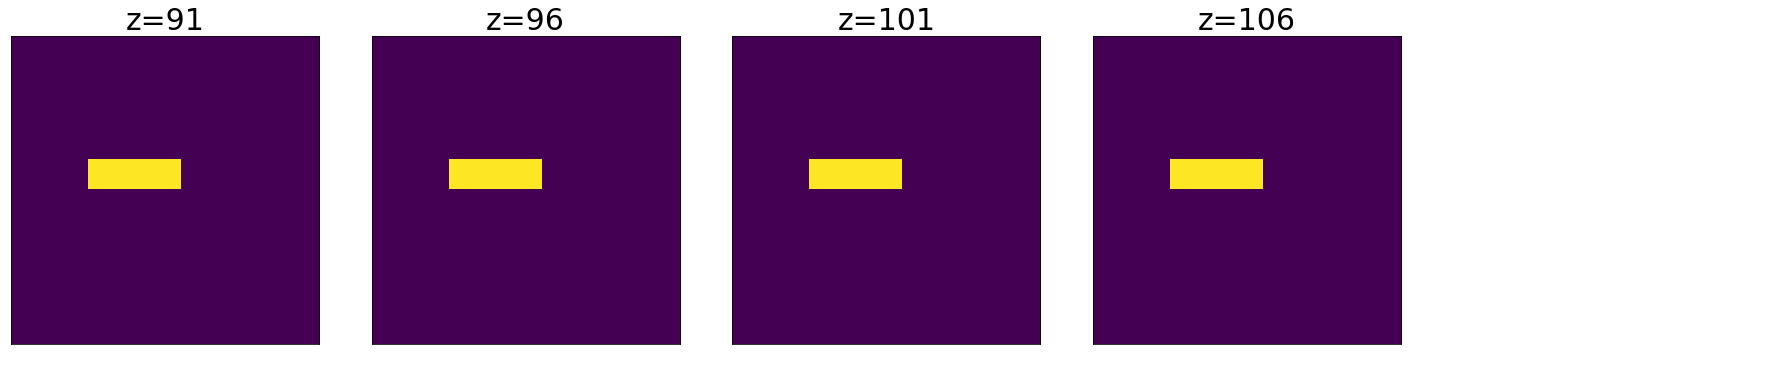

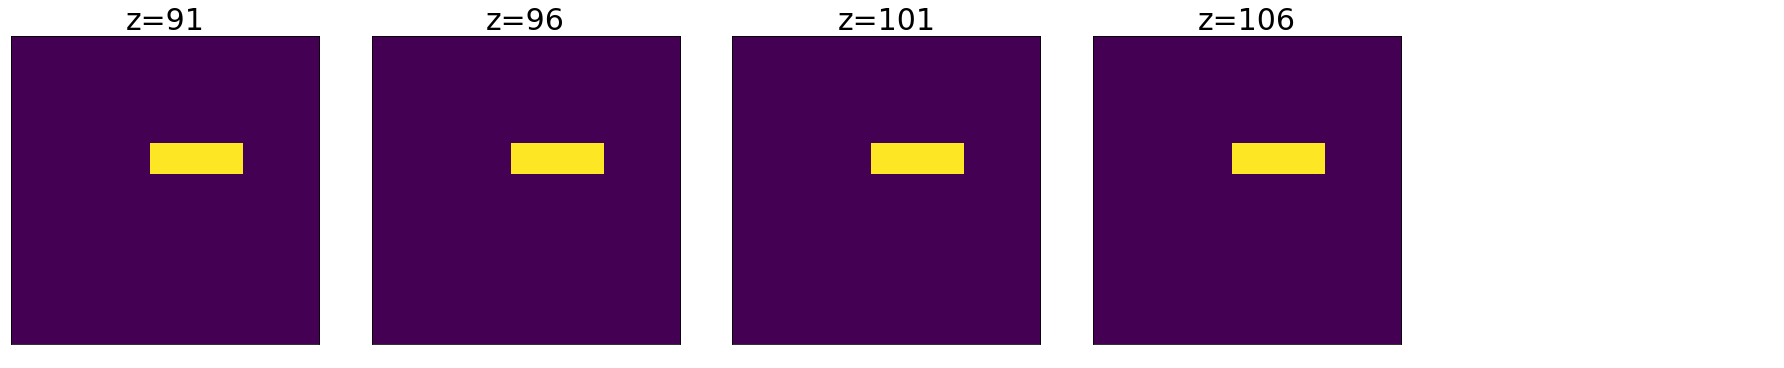

In [6]:
display_volume_sections(v1)
display_volume_sections(v2)

In [7]:
gy1, gx1, gz1 = np.gradient(v1)
gy2, gx2, gz2 = np.gradient(v2)

In [8]:
nz_ys, nz_xs, nz_zs = np.where(v1)
nz_xyzs = np.c_[nz_xs, nz_ys, nz_zs]
n_nz = len(nz_xs)

# Phi = np.c_[np.ones((n_nz,)), nz_xs, nz_ys, nz_zs]

In [9]:
A = np.array([v1[y,x,z] for x,y,z in nz_xyzs])

In [10]:
ctrl_ys, ctrl_xs, ctrl_zs = np.meshgrid(np.arange(0, v1.shape[1], 25), 
                                        np.arange(0, v1.shape[0], 25), 
                                        np.arange(0, v1.shape[2], 25))
ctrl_xyzs = np.c_[ctrl_xs.flatten(), ctrl_ys.flatten(), ctrl_zs.flatten()]
n_ctrl = len(ctrl_xyzs)

ctrl_x_intervals = np.arange(0, v1.shape[1], 25)
ctrl_y_intervals = np.arange(0, v1.shape[0], 25)
ctrl_z_intervals = np.arange(0, v1.shape[2], 25)

n_ctrl_x_intervals = len(np.arange(0, v1.shape[1], 25))
n_ctrl_y_intervals = len(np.arange(0, v1.shape[0], 25))
n_ctrl_z_intervals = len(np.arange(0, v1.shape[2], 25))

In [11]:
def N(i,t): 
    if i <= t and t < i+1:
        return (t-i)**3/6.
    elif i + 1 <= t and t < i+2:
        return (t-i)**2*(i+2-t)/6. + (t-i)*(i+3-t)*(t-i-1)/6. + (i+4-t)*(t-i-1)**2/6.
    elif i+2 <= t and t < i+3:
        return (t-i)*(i+3-t)**2/6. + (i+4-t)*(i+3-t)*(t-i-1)/6. + (i+4-t)**2*(t-i-2)/6.
    elif i+3 <= t and t < i+4:
        return (i+4-t)**3/6.
    else:
        return 0

In [ ]:
NuPx_allTestPts = np.zeros((n_ctrl_x_intervals, n_nz))
for ctrlXInterval_i, ctrl_x in enumerate(ctrl_x_intervals):
#     print ctrlXInterval_i
    for testPt_i, (x, y, z) in enumerate(nz_xyzs):
        NuPx_allTestPts[ctrlXInterval_i, testPt_i] = N(ctrl_x/25., x/25.)
        
NvPy_allTestPts = np.zeros((n_ctrl_y_intervals, n_nz))
for ctrlYInterval_i, ctrl_y in enumerate(ctrl_y_intervals):
#     print ctrlYInterval_i
    for testPt_i, (x, y, z) in enumerate(nz_xyzs):
        NvPy_allTestPts[ctrlYInterval_i, testPt_i] = N(ctrl_y/25., y/25.)
        
NwPz_allTestPts = np.zeros((n_ctrl_z_intervals, n_nz))
for ctrlZInterval_i, ctrl_z in enumerate(ctrl_z_intervals):
#     print ctrlZInterval_i
    for testPt_i, (x, y, z) in enumerate(nz_xyzs):
        NwPz_allTestPts[ctrlZInterval_i, testPt_i] = N(ctrl_z/25., z/25.)

In [44]:
lr = 1

In [45]:
# q1 = np.array([[1,2], [3,4], [5,6]], dtype=object)
# q2 = np.array([['v11','v12'], ['v21','v22']], dtype=object)

# r = np.tensordot(q1, q2, axes=1)
# print r
# print r.shape

In [50]:
NuNvNw_allTestPts = np.array([np.ravel(np.tensordot(np.tensordot(NuPx_allTestPts[:,testPt_i], 
                                                                 NvPy_allTestPts[:,testPt_i], 0), 
                                                    NwPz_allTestPts[:,testPt_i], 0))
                              for testPt_i in range(n_nz)])

In [62]:
def return_gridline_points(xs, ys, w, h):
    grid_points = np.array([(x,y,100) for x in range(w) for y in ys] + [(x,y,100) for x in xs for y in range(h)])
    return grid_points

In [65]:
grid_points = return_gridline_points(range(0,v1.shape[1],10), range(0,v1.shape[0],10), v1.shape[1], v1.shape[0])

NuPx_allGridPts = np.array([[N(ctrl_x/25., x/25.) for gridPt_i, (x, y, z) in enumerate(grid_points)]
                   for ctrlXInterval_i, ctrl_x in enumerate(ctrl_x_intervals)])
NvPy_allGridPts = np.array([[N(ctrl_y/25., y/25.) for gridPt_i, (x, y, z) in enumerate(grid_points)]
                   for ctrlYInterval_i, ctrl_y in enumerate(ctrl_y_intervals)])
NwPz_allGridPts = np.array([[N(ctrl_z/25., z/25.) for gridPt_i, (x, y, z) in enumerate(grid_points)]
                   for ctrlZInterval_i, ctrl_z in enumerate(ctrl_z_intervals)])

NuNvNw_allGridPts = np.array([np.ravel(np.tensordot(np.tensordot(NuPx_allGridPts[:,gridPt_i], 
                                                                 NvPy_allGridPts[:,gridPt_i], 0), 
                                                    NwPz_allGridPts[:,gridPt_i], 0))
                              for gridPt_i in range(len(grid_points))])

0
4000.0


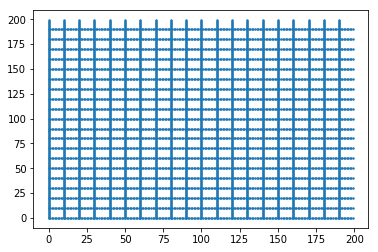

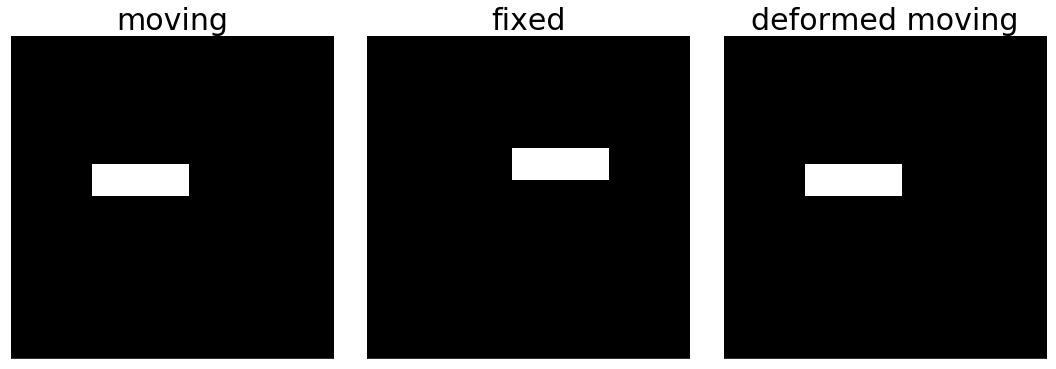

1
4180.0


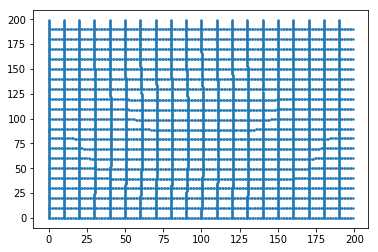

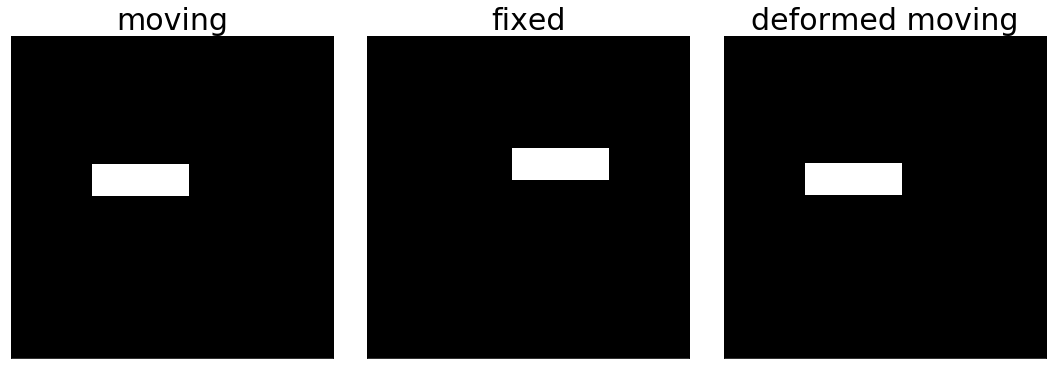

2
5040.0


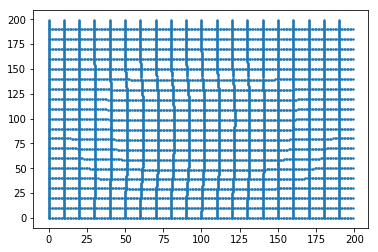

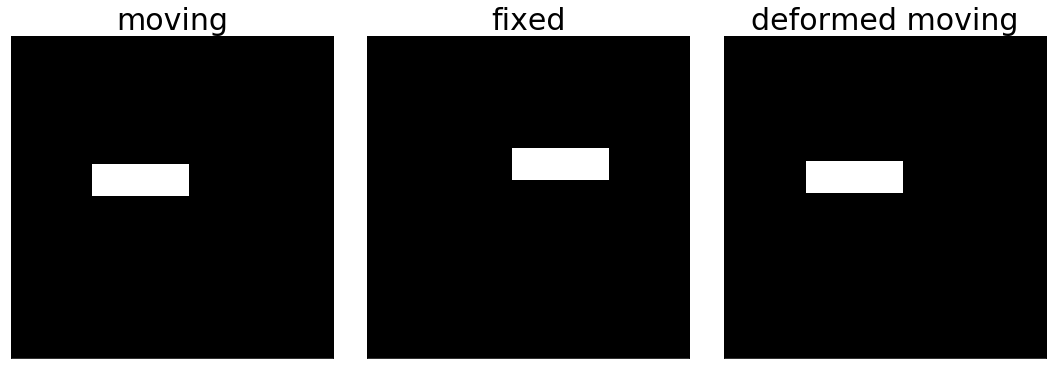

3
5720.0


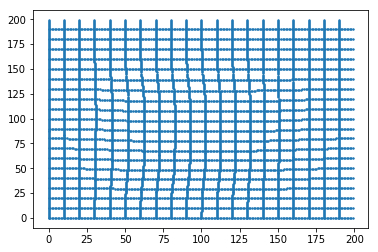

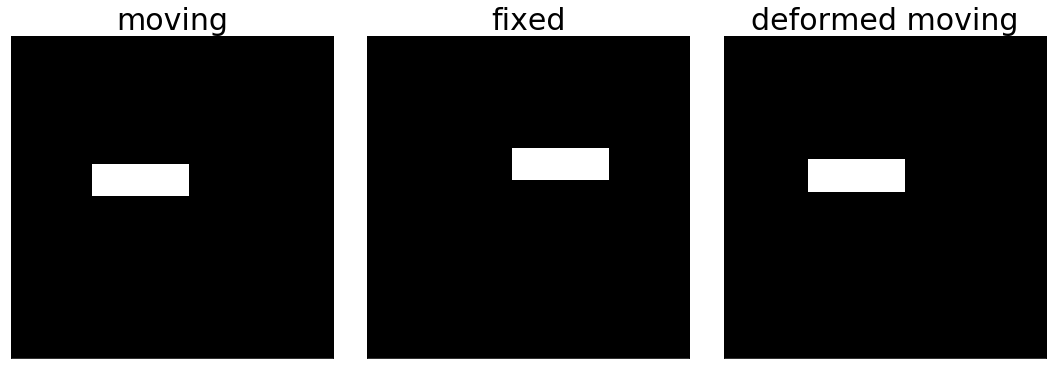

4
5720.0


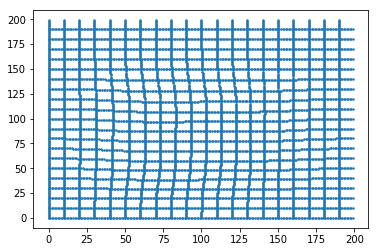

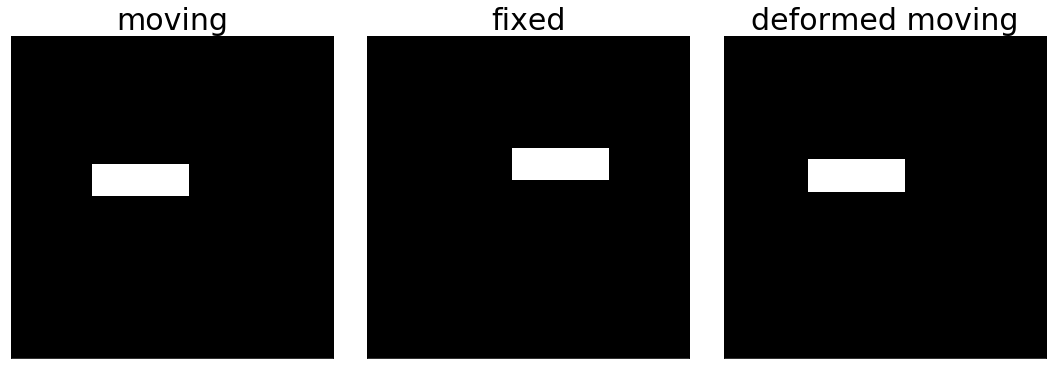

5
6440.0


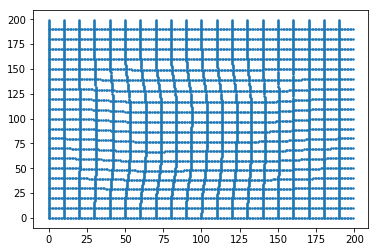

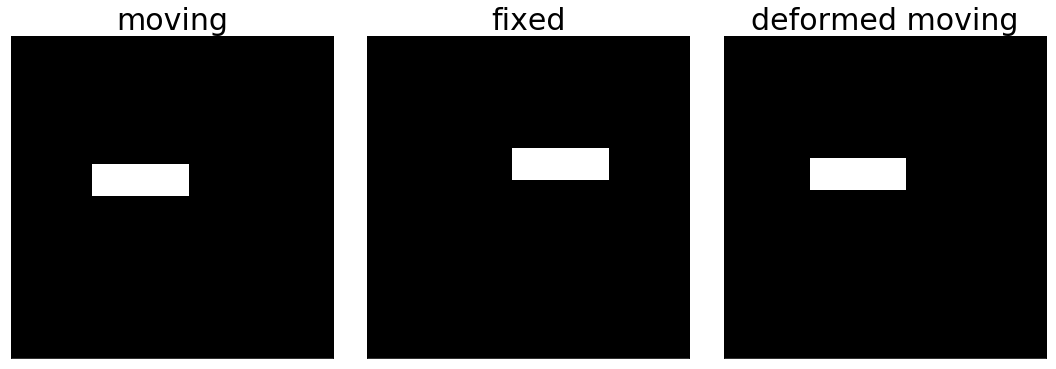

6
6440.0


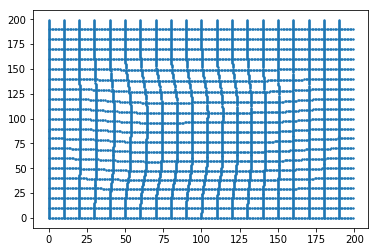

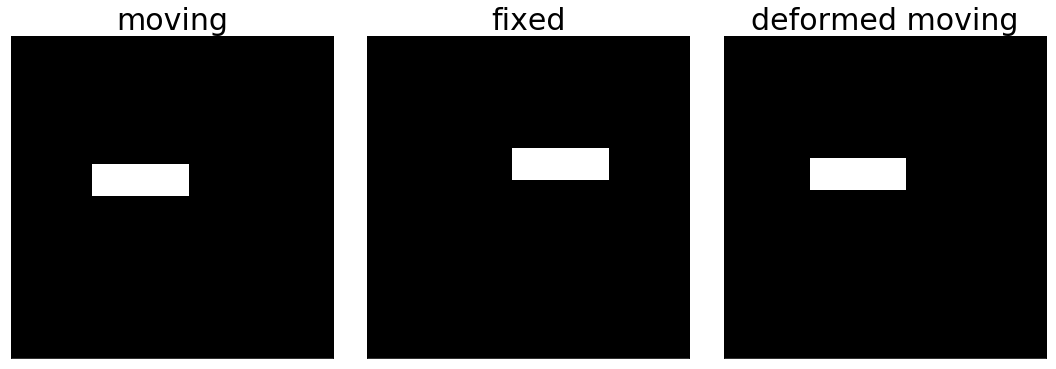

7
7200.0


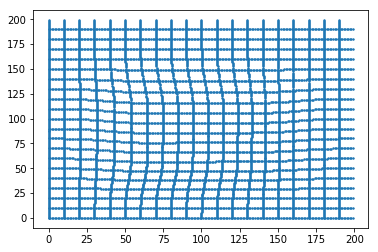

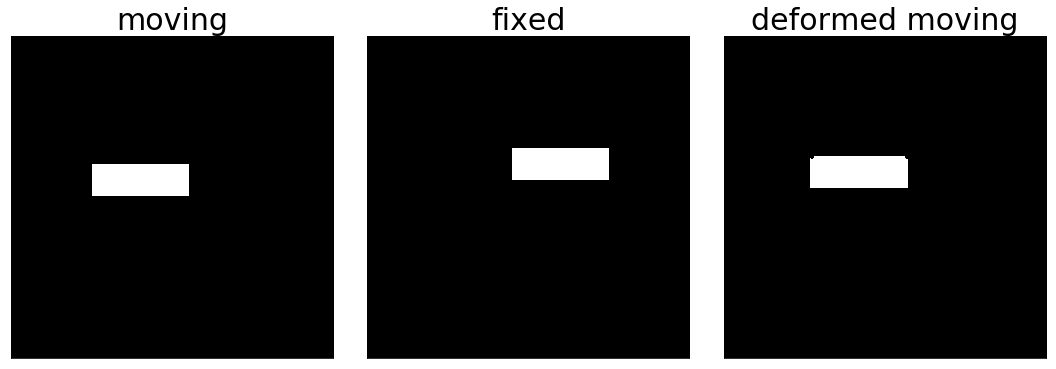

8
7200.0


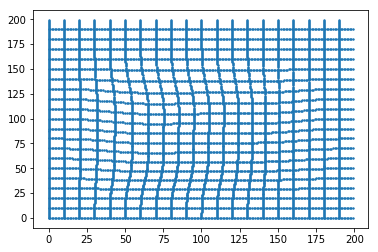

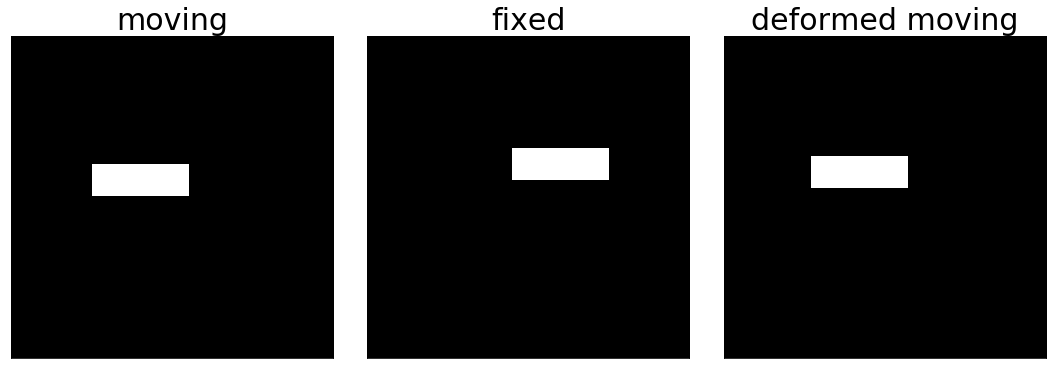

9
7694.0


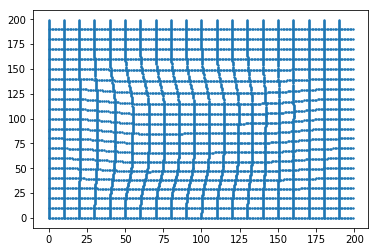

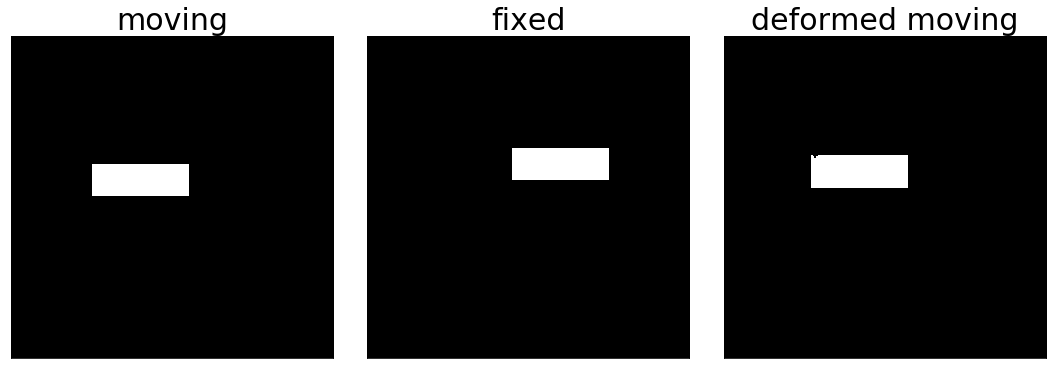

10
8000.0


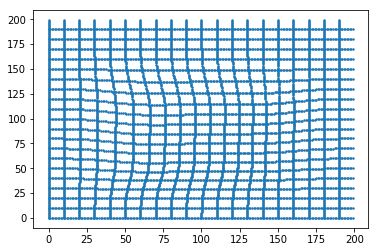

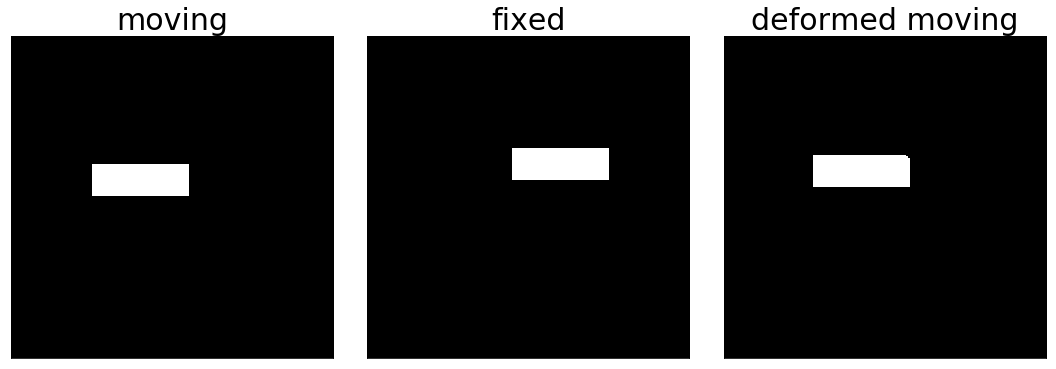

11
8084.0


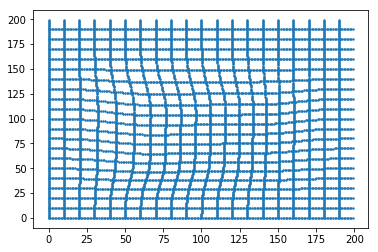

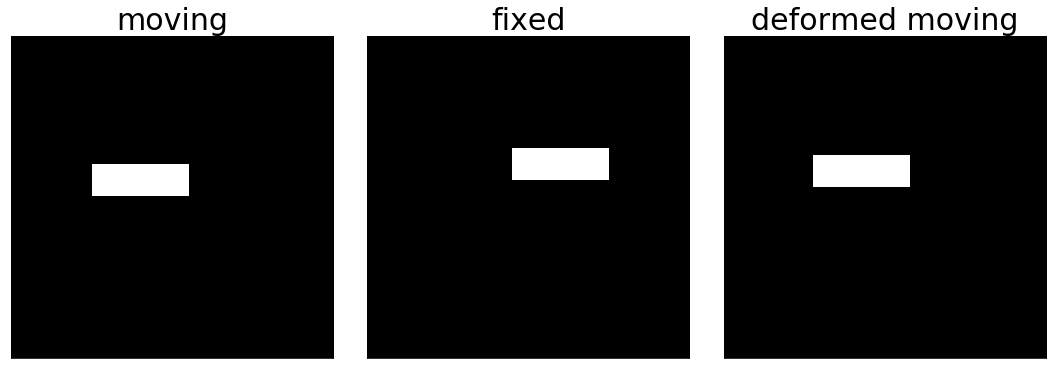

12
8686.0


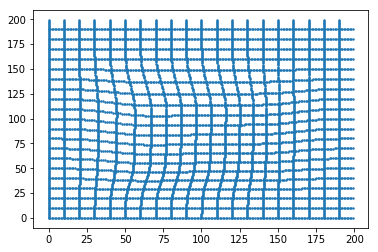

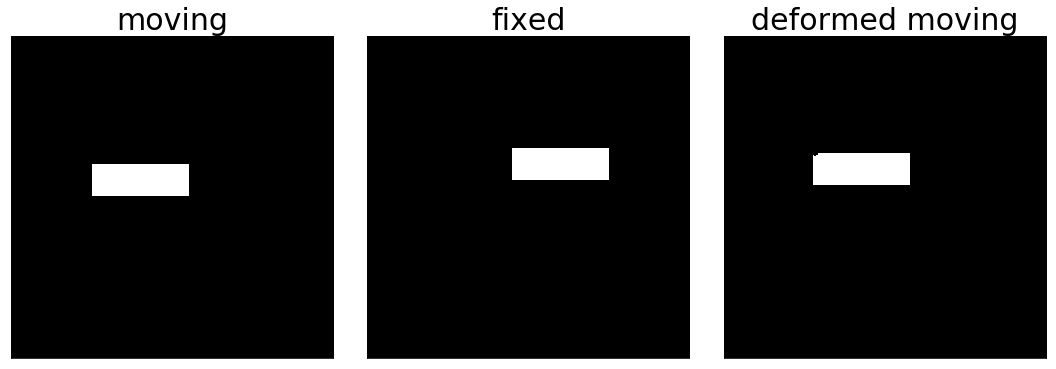

13
8840.0


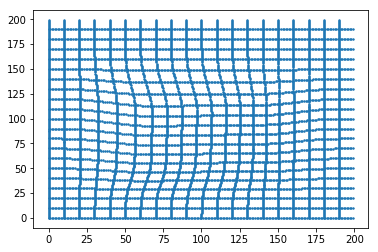

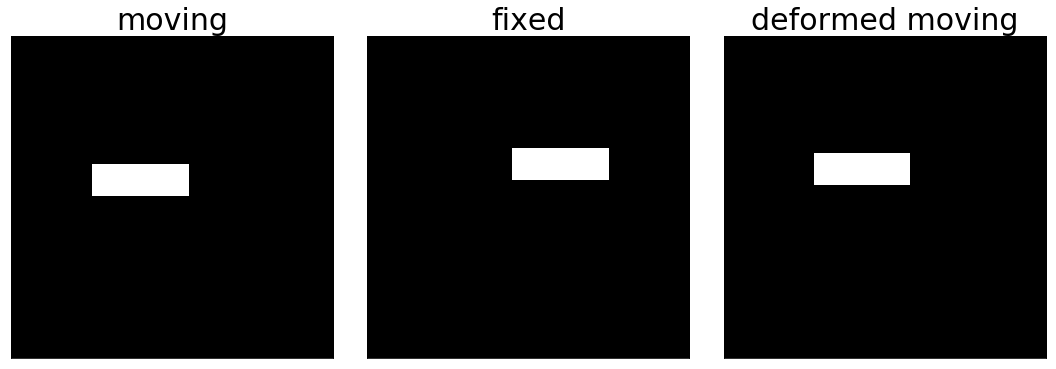

14
9040.0


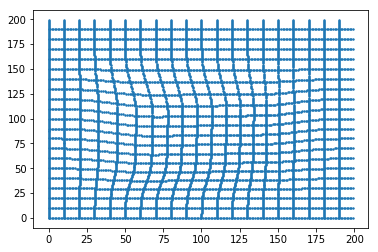

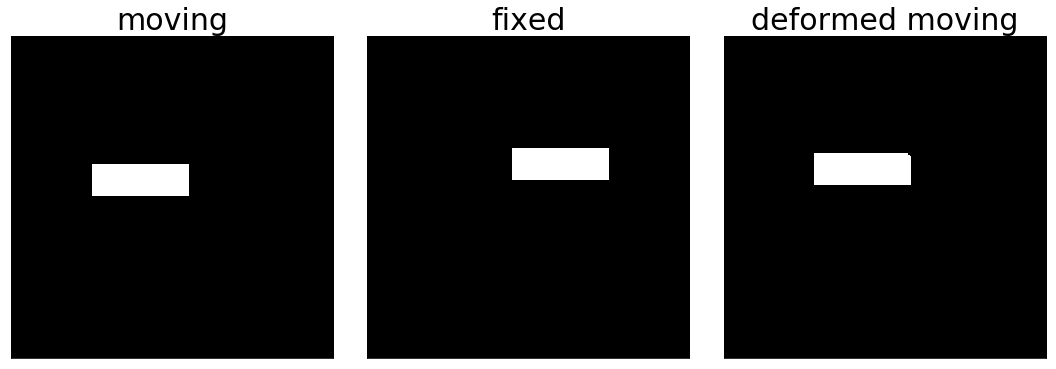

15
9520.0


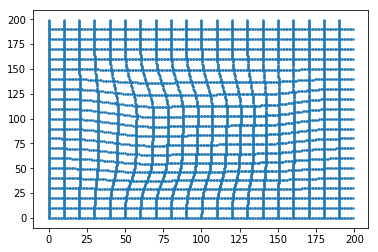

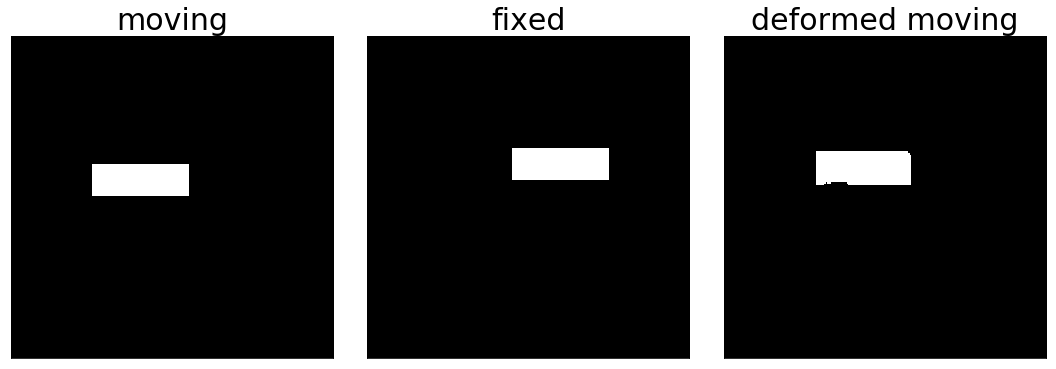

16
9720.0


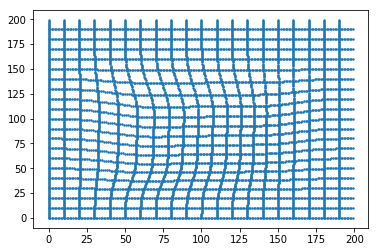

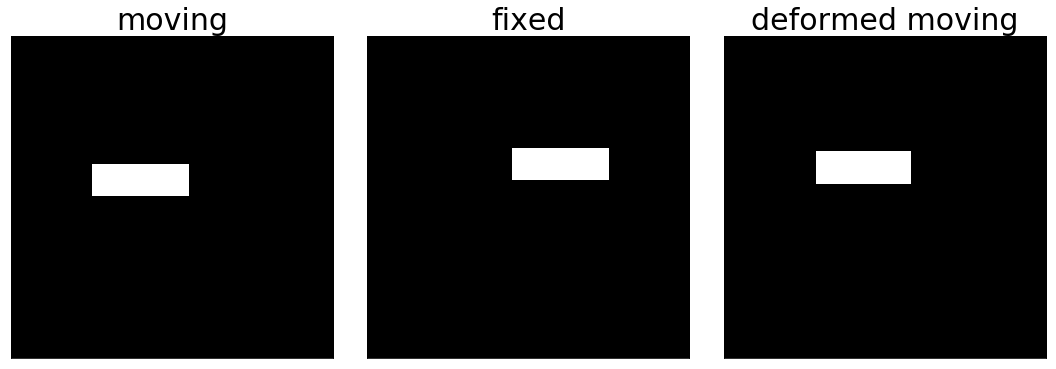

17
9946.0


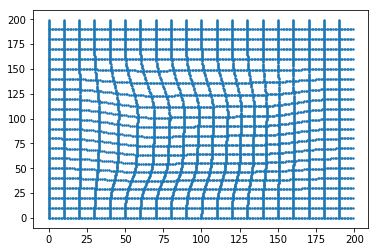

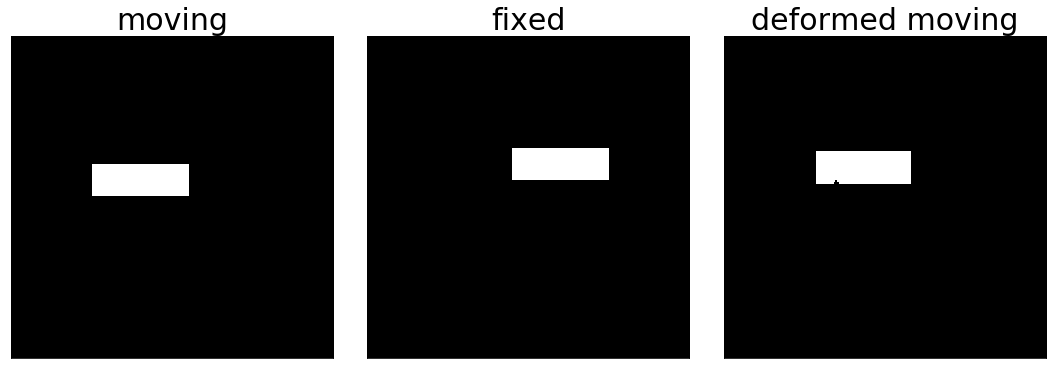

18
10340.0


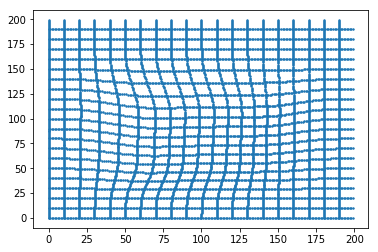

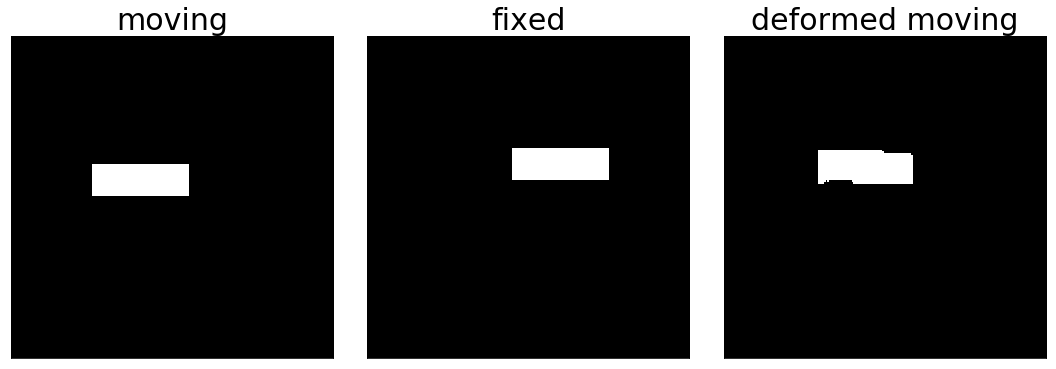

19
10631.0


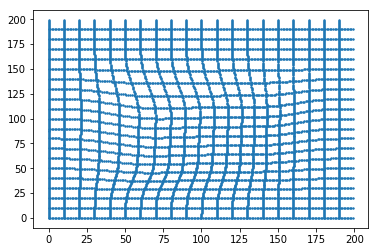

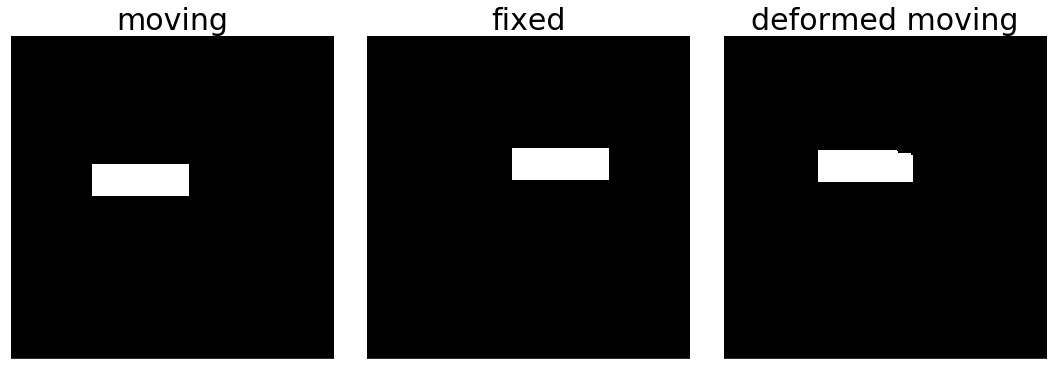

20
10840.0


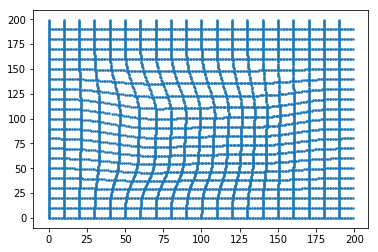

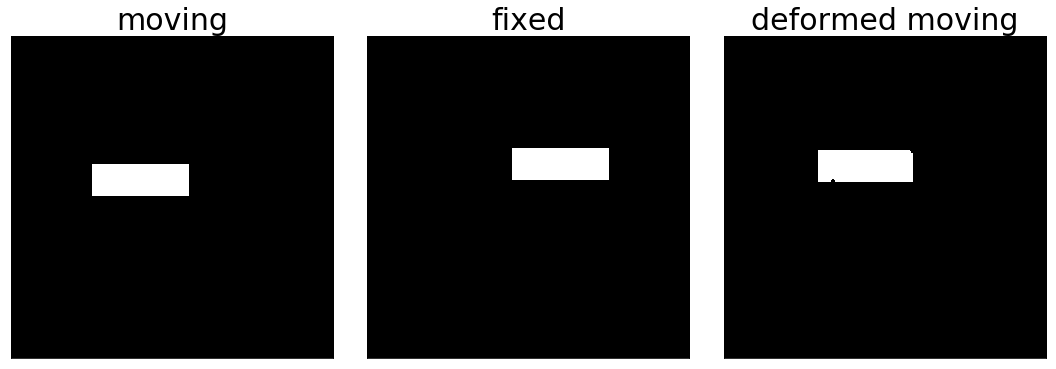

21
11196.0


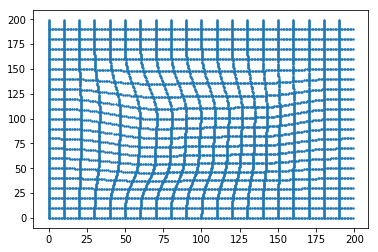

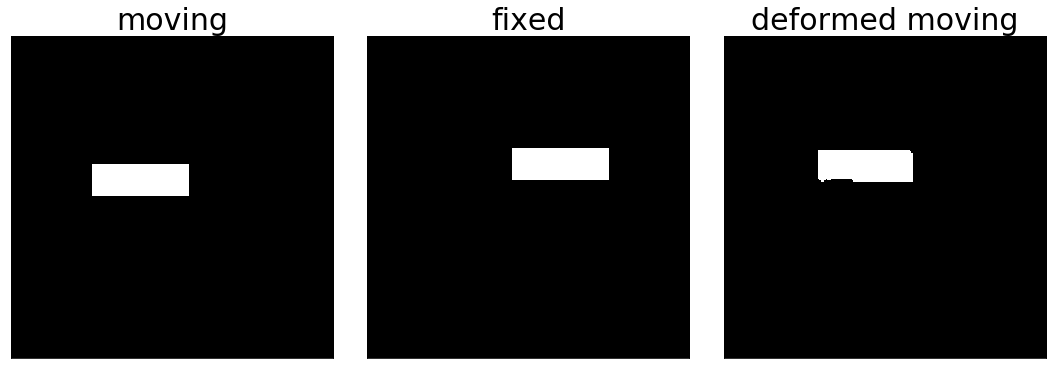

22
11361.0


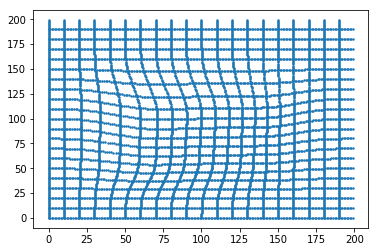

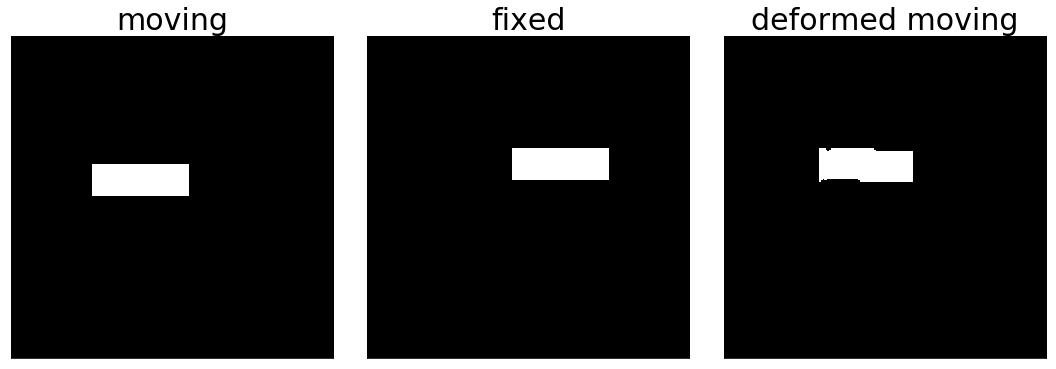

23
11687.0


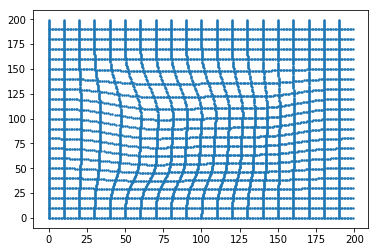

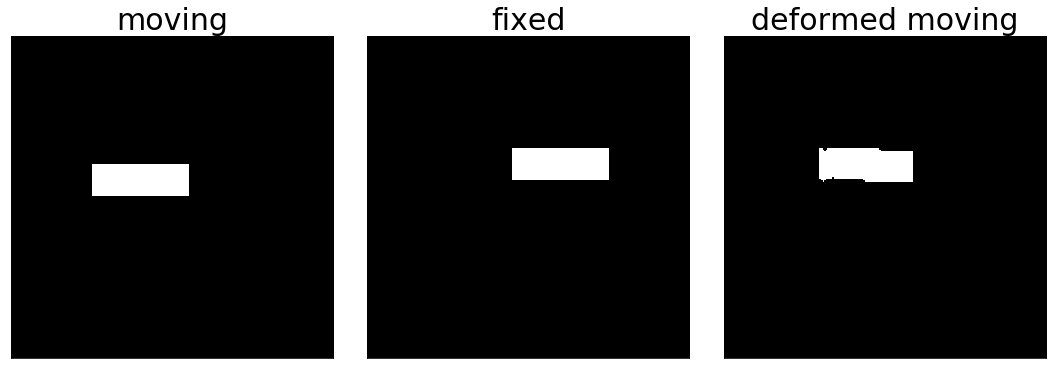

24
11889.0


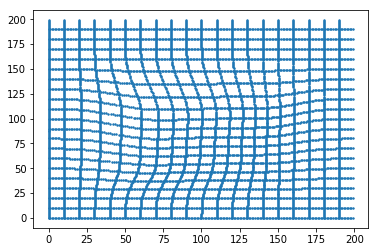

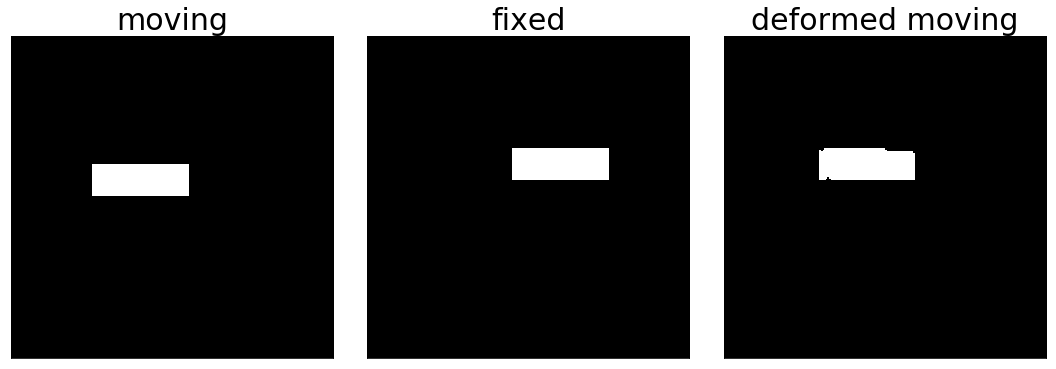

25
12000.0


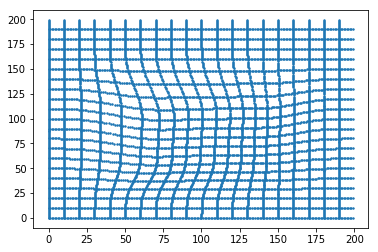

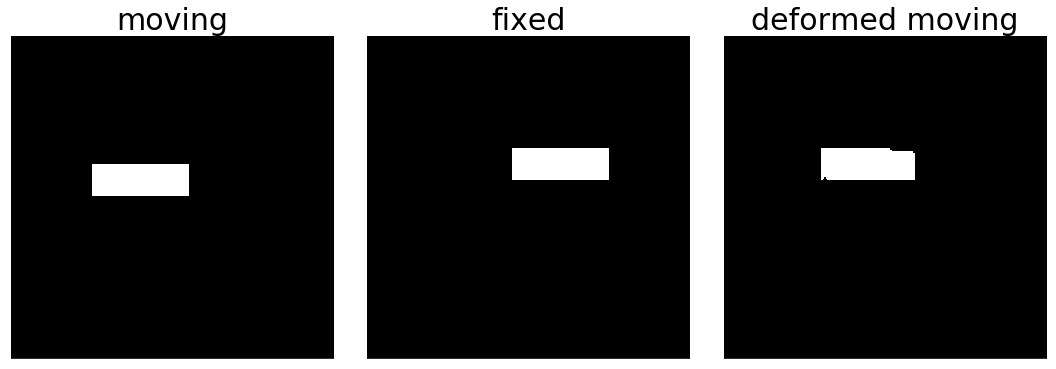

26
12060.0


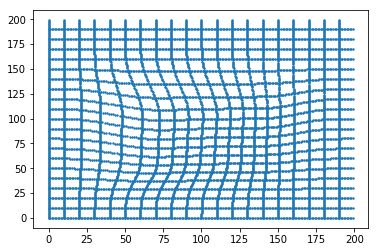

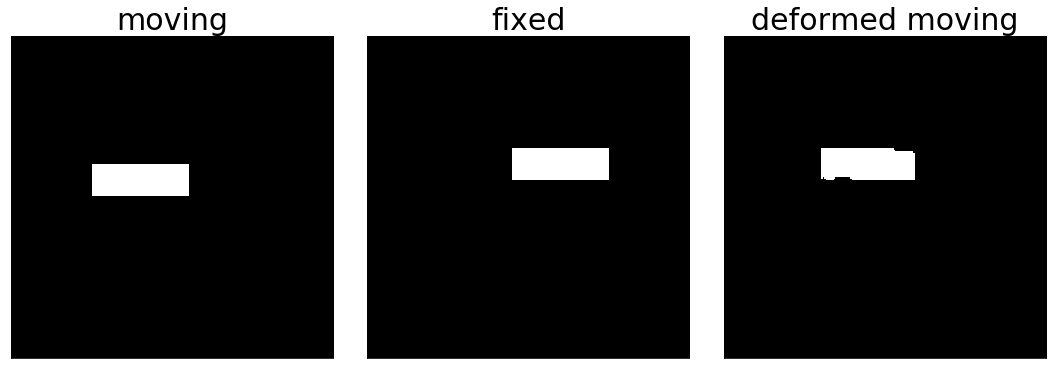

27
12180.0


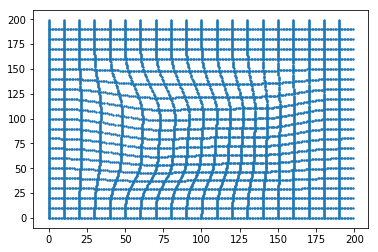

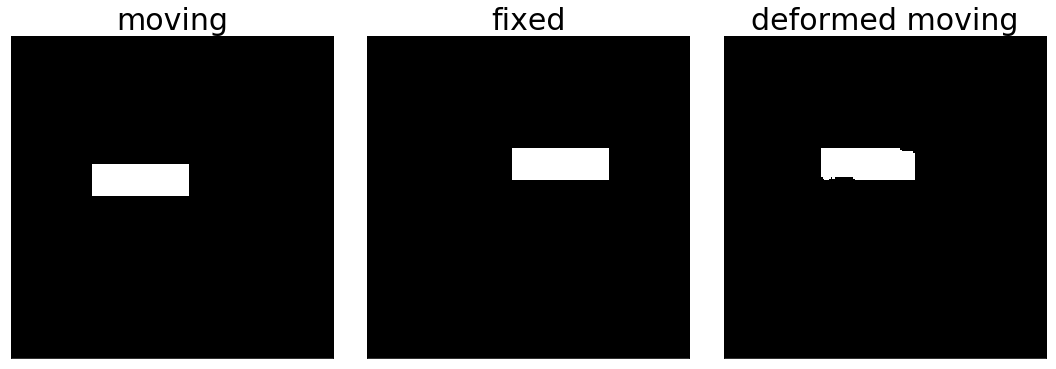

28
12320.0


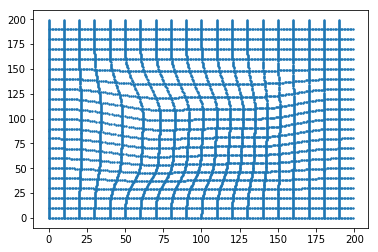

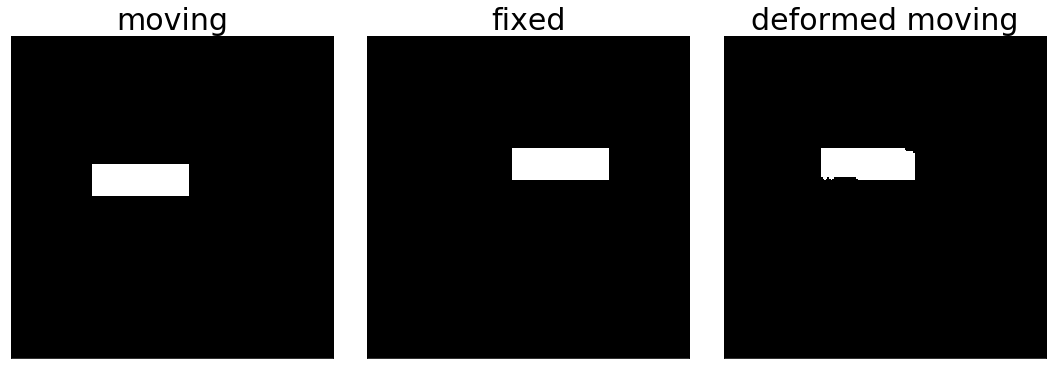

29
12400.0


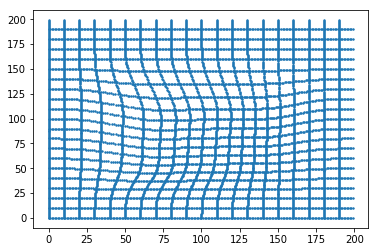

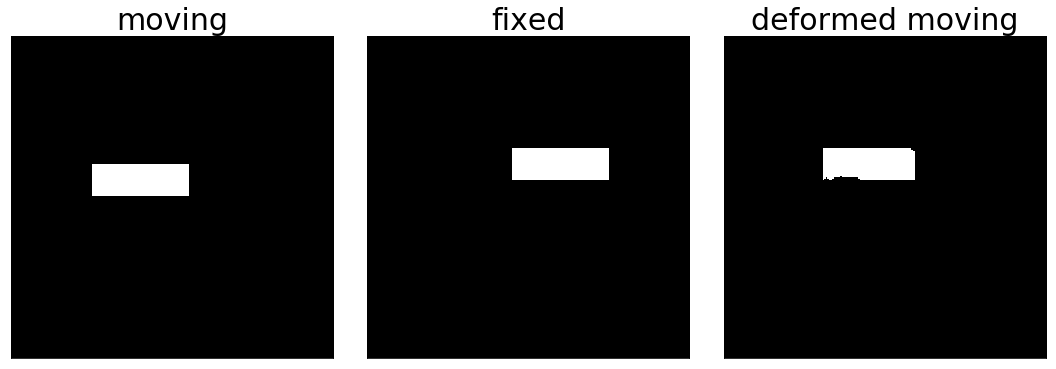

30
12500.0


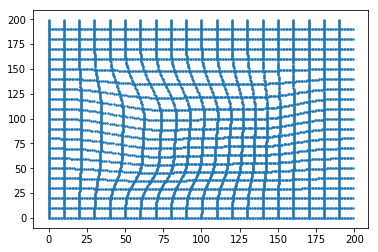

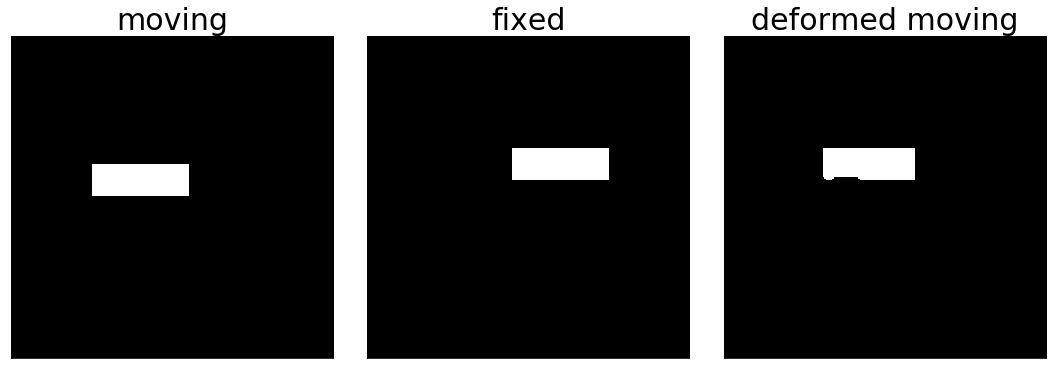

31
12600.0


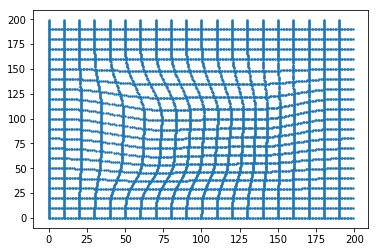

In [ ]:
buvwx = np.zeros((n_ctrl,))
buvwy = np.zeros((n_ctrl,))
buvwz = np.zeros((n_ctrl,))

dCdbuvwx_historical = 0
dCdbuvwy_historical = 0
dCdbuvwz_historical = 0

for iteration in range(100):
    print iteration
    
    sum_uvw_NuNvNwbuvwx = np.dot(NuNvNw_allTestPts, buvwx)
    sum_uvw_NuNvNwbuvwy = np.dot(NuNvNw_allTestPts, buvwy)
    sum_uvw_NuNvNwbuvwz = np.dot(NuNvNw_allTestPts, buvwz)

    q = nz_xyzs + np.c_[sum_uvw_NuNvNwbuvwx, sum_uvw_NuNvNwbuvwy, sum_uvw_NuNvNwbuvwz]

    ###################################
    
    S = np.array([v2[int(y), int(x), int(z)] for x,y,z in q])
    F = np.dot(A, S)
    print F
    
    sum_uvw_NuNvNwbuvwx_allGridPts = np.dot(NuNvNw_allGridPts, buvwx)
    sum_uvw_NuNvNwbuvwy_allGridPts = np.dot(NuNvNw_allGridPts, buvwy)
    sum_uvw_NuNvNwbuvwz_allGridPts = np.dot(NuNvNw_allGridPts, buvwz)

    warped_grid_points = grid_points + np.c_[sum_uvw_NuNvNwbuvwx_allGridPts, sum_uvw_NuNvNwbuvwy_allGridPts, sum_uvw_NuNvNwbuvwz_allGridPts]
    
    plt.scatter(warped_grid_points[:,0], warped_grid_points[:,1], s=1)
    plt.show()
    
    #####################################
    
    dSdq_allTestPts = np.array([(gx2[y,x,z], gy2[y,x,z], gz2[y,x,z]) for x,y,z in q.astype(np.int)])

    dqxdbuvwx_allTestPts = np.array([np.ravel(np.tensordot(np.tensordot(NuPx_allTestPts[:,testPt_i], 
                                                               NvPy_allTestPts[:,testPt_i], 0), 
                                                  NwPz_allTestPts[:,testPt_i], 0))
                                     for testPt_i in range(n_nz)])
    dqydbuvwy_allTestPts = dqxdbuvwx_allTestPts
    dqzdbuvwz_allTestPts = dqxdbuvwx_allTestPts
    
    dSdbuvwx_allTestPts = dSdq_allTestPts[:,0][:,None] * dqxdbuvwx_allTestPts
    dSdbuvwy_allTestPts = dSdq_allTestPts[:,1][:,None] * dqydbuvwy_allTestPts
    dSdbuvwz_allTestPts = dSdq_allTestPts[:,2][:,None] * dqzdbuvwz_allTestPts

    dFdbuvwx = np.dot(A, dSdbuvwx_allTestPts)
    dFdbuvwy = np.dot(A, dSdbuvwy_allTestPts)
    dFdbuvwz = np.dot(A, dSdbuvwz_allTestPts)

#     gamma = 0
#     dCdWx = dFdWx - gamma * dQdWx
#     dCdWy = dFdWy - gamma * dQdWy
#     dCdWz = dFdWz - gamma * dQdWz
    
    dCdbuvwx = dFdbuvwx
    dCdbuvwy = dFdbuvwy
    dCdbuvwz = dFdbuvwz
    
#     print dCdbuvwx
#     print dCdbuvwy
#     print dCdbuvwz
    
    # AdaGrad Rule
    dCdbuvwx_historical += dCdbuvwx**2
    dCdbuvwy_historical += dCdbuvwy**2
    dCdbuvwz_historical += dCdbuvwz**2
    
    dCdbuvwx_adjusted = dCdbuvwx / np.sqrt(dCdbuvwx_historical + 1e-10)
    dCdbuvwy_adjusted = dCdbuvwy / np.sqrt(dCdbuvwy_historical + 1e-10)
    dCdbuvwz_adjusted = dCdbuvwz / np.sqrt(dCdbuvwz_historical + 1e-10)
    
    buvwx = buvwx + lr * dCdbuvwx_adjusted
    buvwy = buvwy + lr * dCdbuvwy_adjusted
    buvwz = buvwz + lr * dCdbuvwz_adjusted
    
    ###############################
    
    nzs_m_aligned_to_f = (nz_xyzs + np.c_[sum_uvw_NuNvNwbuvwx, sum_uvw_NuNvNwbuvwy, sum_uvw_NuNvNwbuvwz]).astype(np.int)
    
    ydim_f, xdim_f, zdim_f = v2.shape

    volume_m_aligned_to_f = np.zeros(v2.shape, v1.dtype)

    xs_f, ys_f, zs_f = nzs_m_aligned_to_f.T

    valid = (xs_f >= 0) & (ys_f >= 0) & (zs_f >= 0) & \
    (xs_f < xdim_f) & (ys_f < ydim_f) & (zs_f < zdim_f)

    xs_m, ys_m, zs_m = nz_xyzs.T

    volume_m_aligned_to_f[ys_f[valid], xs_f[valid], zs_f[valid]] = \
    v1[ys_m[valid], xs_m[valid], zs_m[valid]]

    del nzs_m_aligned_to_f

    if np.issubdtype(volume_m_aligned_to_f.dtype, np.float):
        dense_volume = fill_sparse_score_volume(volume_m_aligned_to_f)
    elif np.issubdtype(volume_m_aligned_to_f.dtype, np.integer):
        dense_volume = fill_sparse_volume(volume_m_aligned_to_f)
    else:
        raise Exception('transform_volume: Volume must be either float or int.')
    
    display_images_in_grids([v1[..., 100], v2[..., 100], dense_volume[..., 100]],
                        nc=3, titles=['moving', 'fixed', 'deformed moving'],
                       cmap=plt.cm.gray, vmin=0, vmax=1)
    
    #################################